In [1]:
!pip install mlflow
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 15.1 MB/s eta 0:00:00


In [2]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

In [ ]:
# # Define the MLflow tracking URI with SQLite
# MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

# # Start the MLflow server using subprocess
# subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI, "--port", "5000"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

In [ ]:
# # Set MLflow tracking URI
# mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# # Set or create an experiment
# mlflow.set_experiment("AQI Feature Selection")

2025/07/03 00:05:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/03 00:05:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/07/03 00:05:11 INFO mlflow.tracking.fluent: Experiment with name 'AQI Feature Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/mlruns/1', creation_time=1751501111108, experiment_id='1', last_update_time=1751501111108, lifecycle_stage='active', name='AQI Feature Selection', tags={}>

In [ ]:
# # Set up ngrok for exposing the MLflow UI
# print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
# conf.get_default().auth_token = getpass.getpass()

# # Expose the MLflow UI on port 5000
# port = 5000
# public_url = ngrok.connect(port).public_url
# print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel "https://9534-35-227-155-103.ngrok-free.app" -> "http://127.0.0.1:5000"


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Restore from Drive
# !cp -r /content/drive/MyDrive/mlflow_backup/mlruns .
# !cp /content/drive/MyDrive/mlflow_backup/mlflow.db .

# Restore mlruns and database
!cp -r /content/drive/MyDrive/mlflow_backup/mlruns /content/
!cp /content/drive/MyDrive/mlflow_backup/mlflow.db /content/


import mlflow

# Set tracking URI to the restored local SQLite file
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# (Optional) Re-set your experiment name if needed
mlflow.set_experiment("AQI Feature Selection")

import subprocess

# Start MLflow UI server on port 5000 using the restored database
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db", "--port", "5000"])

from pyngrok import ngrok, conf
import getpass

# Authenticate ngrok
conf.get_default().auth_token = getpass.getpass("🔐 Enter your ngrok authtoken: ")

# Expose port 5000
public_url = ngrok.connect(5000)
print(f"🌐 Access MLflow UI at: {public_url}")

2025/07/03 23:47:22 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/03 23:47:22 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


🔐 Enter your ngrok authtoken: ··········
🌐 Access MLflow UI at: NgrokTunnel: "https://9a0a-34-82-169-161.ngrok-free.app" -> "http://localhost:5000"


In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.8 MB/s eta 0:00:00


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data_with_lags.csv")

In [ ]:
# features and target
target = "aqi_us"
excluded_cols = ["aqi_us", "datetime"]  # you may also test with or without lag features
features = [col for col in df.columns if col not in excluded_cols]

X = df[features]
y = df[target]

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# CV for Random Forest

rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 12, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

In [ ]:
print("✅ Best Parameters for Random Forest:")
print(rf_grid.best_params_)

print("\n📉 Best CV MSE (neg):", rf_grid.best_score_)
print("📈 Best CV RMSE:", (-rf_grid.best_score_)**0.5)

✅ Best Parameters for Random Forest:
{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📉 Best CV MSE (neg): -20.67764892604788
📈 Best CV RMSE: 4.54726829272783


In [ ]:
# Optuna for Random Forest

def rf_objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    model = RandomForestRegressor(**rf_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=25)
best_rf_optuna = RandomForestRegressor(**rf_study.best_params, random_state=42)
best_rf_optuna.fit(X_train, y_train)

[I 2025-07-02 23:33:01,767] A new study created in memory with name: no-name-7c2aa263-f847-4b93-b55a-d87679f917c3
[I 2025-07-02 23:33:02,803] Trial 0 finished with value: 23.319851501069184 and parameters: {'n_estimators': 209, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 23.319851501069184.
[I 2025-07-02 23:33:03,567] Trial 1 finished with value: 16.950949689358886 and parameters: {'n_estimators': 138, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 16.950949689358886.
[I 2025-07-02 23:33:04,152] Trial 2 finished with value: 37.46162901060001 and parameters: {'n_estimators': 169, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 16.950949689358886.
[I 2025-07-02 23:33:05,181] Trial 3 finished with value: 29.771077189028702 and parameters: {'n_estimators': 212, 'max_depth': 6, 'min_

RandomForestRegressor(max_depth=16, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=3, n_estimators=247, random_state=42)

In [ ]:
# CV for XGboost

xgb = XGBRegressor(random_state=42)
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_


In [ ]:
print("✅ Best Parameters for Xgboost:")
print(xgb_grid.best_params_)

print("\n📉 Best CV MSE (neg):", xgb_grid.best_score_)
print("📈 Best CV RMSE:", (-xgb_grid.best_score_)**0.5)

✅ Best Parameters for Xgboost:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

📉 Best CV MSE (neg): -6.361647605895996
📈 Best CV RMSE: 2.522230680547677


In [ ]:
# Optuna for XGboost

def xgb_objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0)
    }
    model = XGBRegressor(**xgb_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=25)
best_xgb_optuna = XGBRegressor(**xgb_study.best_params, random_state=42)
best_xgb_optuna.fit(X_train, y_train)

[I 2025-07-02 23:49:06,905] A new study created in memory with name: no-name-bacc4d6a-465c-44ad-ba7a-2be47ccfc8ed
[I 2025-07-02 23:49:11,059] Trial 0 finished with value: 6.505166530609131 and parameters: {'n_estimators': 193, 'max_depth': 7, 'learning_rate': 0.02560103310015175, 'subsample': 0.9960833643175137, 'colsample_bytree': 0.900857755732041, 'gamma': 0.06883004082819333, 'reg_alpha': 0.6725514327483438, 'reg_lambda': 0.4845532519327701}. Best is trial 0 with value: 6.505166530609131.
[I 2025-07-02 23:49:11,487] Trial 1 finished with value: 5.848228454589844 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.276152133814367, 'subsample': 0.7925581929893469, 'colsample_bytree': 0.796959575310974, 'gamma': 0.7984322955931691, 'reg_alpha': 0.3392150138979275, 'reg_lambda': 0.09034829265176292}. Best is trial 1 with value: 5.848228454589844.
[I 2025-07-02 23:49:12,541] Trial 2 finished with value: 5.258772373199463 and parameters: {'n_estimators': 165, 'max_de

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8842366728297926, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.6256076421983944,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1336393974465606,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=245, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Extract feature importances
rf_importances = pd.Series(best_rf_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:15]
xgb_importances = pd.Series(best_xgb_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [ ]:
# Plotting Function
def plot_importances(importances, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-23-78317768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


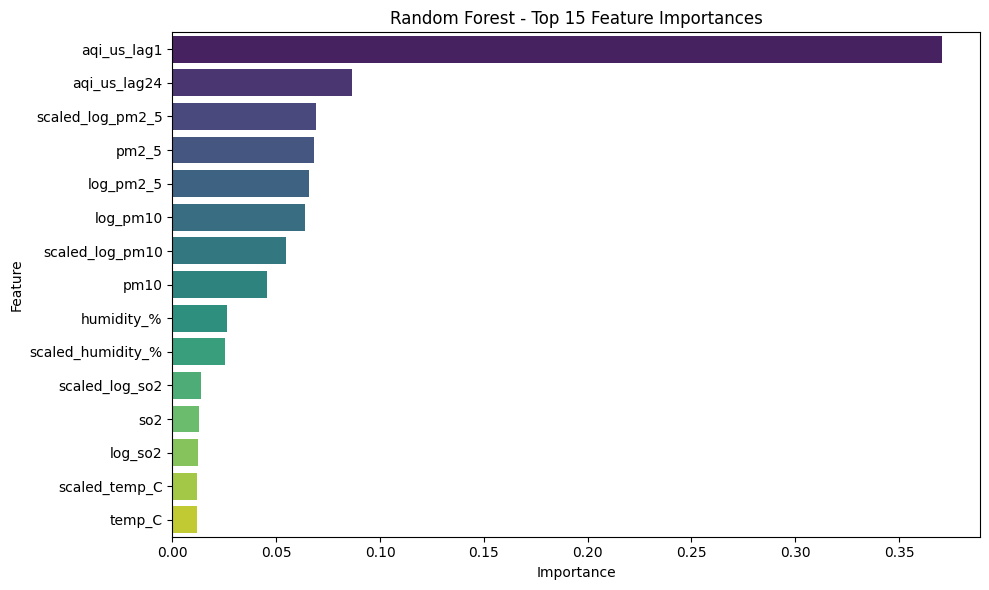

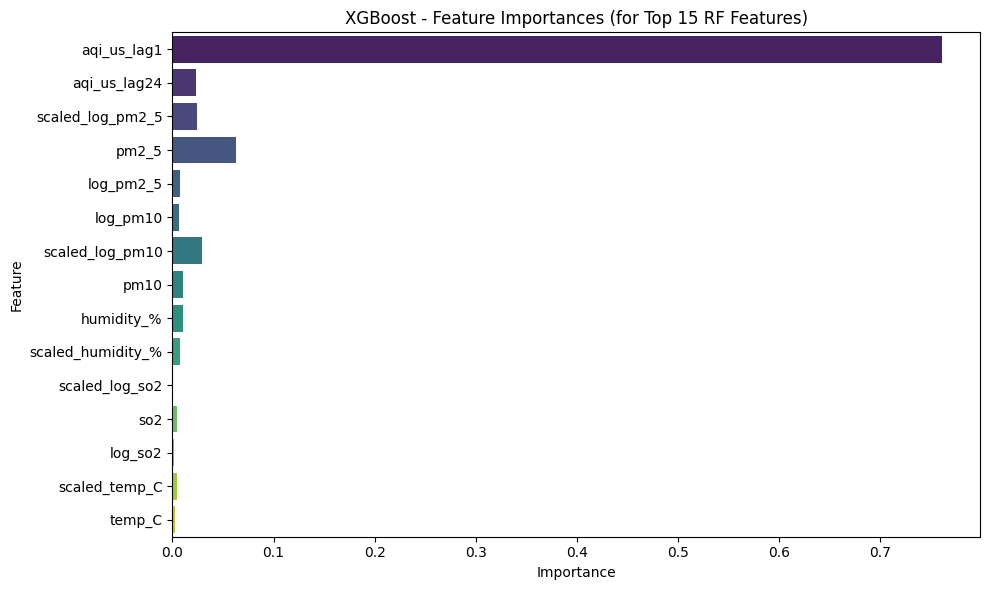

In [ ]:
# Random Forest
plot_importances(rf_importances, "Random Forest - Top 15 Feature Importances")

# XGBoost
xgb_top15 = xgb_importances[rf_importances.index]
plot_importances(xgb_top15, "XGBoost - Feature Importances (for Top 15 RF Features)")

In [ ]:
# Table of Importances

importance_df = pd.DataFrame({
    "Feature": rf_importances.index,
    "RandomForest_Importance": rf_importances.values,
    "XGBoost_Importance": xgb_importances[rf_importances.index].values
})

print("\n📊 Top 15 Features by Model Importance:\n")
print(importance_df.head(15).to_string(index=False))


📊 Top 15 Features by Model Importance:

          Feature  RandomForest_Importance  XGBoost_Importance
      aqi_us_lag1                 0.370454            0.760788
     aqi_us_lag24                 0.086476            0.022964
 scaled_log_pm2_5                 0.068963            0.024015
            pm2_5                 0.068007            0.062496
        log_pm2_5                 0.065638            0.007553
         log_pm10                 0.063878            0.006959
  scaled_log_pm10                 0.054836            0.029524
             pm10                 0.045496            0.010066
       humidity_%                 0.026385            0.010648
scaled_humidity_%                 0.025381            0.007474
   scaled_log_so2                 0.013888            0.000000
              so2                 0.012871            0.004640
          log_so2                 0.012417            0.001384
    scaled_temp_C                 0.011928            0.004582
           tem

In [ ]:
import mlflow.sklearn
import mlflow.xgboost

# Common logging helper
def log_model_mlflow(model, model_name, params, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Predict and log metrics
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = mse**0.5
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        # Log model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        print(f"✅ Logged {model_name} to MLflow with RMSE: {rmse:.3f}")

In [ ]:
# Log all 4 models

# 1. RF (CV)
log_model_mlflow(
    best_rf,
    "RandomForest_CV",
    rf_grid.best_params_,
    X_test,
    y_test
)

# 2. RF (Optuna)
log_model_mlflow(
    best_rf_optuna,
    "RandomForest_Optuna",
    rf_study.best_params,
    X_test,
    y_test
)

# 3. XGB (CV)
log_model_mlflow(
    best_xgb,
    "XGBoost_CV",
    xgb_grid.best_params_,
    X_test,
    y_test
)

# 4. XGB (Optuna)
log_model_mlflow(
    best_xgb_optuna,
    "XGBoost_Optuna",
    xgb_study.best_params,
    X_test,
    y_test
)

2025/07/03 00:12:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 00:12:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 00:12:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged RandomForest_CV to MLflow with RMSE: 3.239


2025/07/03 00:12:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 00:12:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged RandomForest_Optuna to MLflow with RMSE: 3.212


2025/07/03 00:12:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 00:12:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged XGBoost_CV to MLflow with RMSE: 1.995


2025/07/03 00:12:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged XGBoost_Optuna to MLflow with RMSE: 1.984


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Backup MLflow data to Drive
!cp -r mlruns /content/drive/MyDrive/mlflow_backup/
!cp mlflow.db /content/drive/MyDrive/mlflow_backup/

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data_with_all_features.csv")

In [ ]:
# features and target
target = "aqi_us"
excluded_cols = ["aqi_us", "datetime"]  # you may also test with or without lag features
features = [col for col in df.columns if col not in excluded_cols]

X = df[features]
y = df[target]

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# CV for Random Forest

rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [6, 20, None],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", "log2"]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print("✅ Best Parameters for Random Forest:")
print(rf_grid.best_params_)

print("\n📉 Best CV MSE (neg):", rf_grid.best_score_)
print("📈 Best CV RMSE:", (-rf_grid.best_score_)**0.5)

✅ Best Parameters for Random Forest:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

📉 Best CV MSE (neg): -19.212479603998815
📈 Best CV RMSE: 4.383204262180673


In [ ]:
# Optuna for Random Forest

def rf_objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    model = RandomForestRegressor(**rf_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=50)
best_rf_optuna = RandomForestRegressor(**rf_study.best_params, random_state=42)
best_rf_optuna.fit(X_train, y_train)

[I 2025-07-03 22:04:47,127] A new study created in memory with name: no-name-fe6ec9e5-19fd-43af-bafd-ae332e410447
[I 2025-07-03 22:04:47,998] Trial 0 finished with value: 16.696699413031233 and parameters: {'n_estimators': 173, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 16.696699413031233.
[I 2025-07-03 22:04:49,849] Trial 1 finished with value: 10.289278069171937 and parameters: {'n_estimators': 248, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 10.289278069171937.
[I 2025-07-03 22:04:52,036] Trial 2 finished with value: 13.08543354012004 and parameters: {'n_estimators': 376, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 10.289278069171937.
[I 2025-07-03 22:04:55,587] Trial 3 finished with value: 10.695408597306498 and parameters: {'n_estimators': 460, 'max_depth': 12, 'min_

RandomForestRegressor(max_depth=19, max_features='sqrt', n_estimators=448,
                      random_state=42)

In [ ]:
# CV for XGboost

xgb = XGBRegressor(random_state=42)
xgb_param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print("✅ Best Parameters for Xgboost:")
print(xgb_grid.best_params_)

print("\n📉 Best CV MSE (neg):", xgb_grid.best_score_)
print("📈 Best CV RMSE:", (-xgb_grid.best_score_)**0.5)

✅ Best Parameters for Xgboost:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}

📉 Best CV MSE (neg): -5.696361875534057
📈 Best CV RMSE: 2.386705234320748


In [ ]:
# Optuna for XGboost

def xgb_objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0)
    }
    model = XGBRegressor(**xgb_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=50)
best_xgb_optuna = XGBRegressor(**xgb_study.best_params, random_state=42)
best_xgb_optuna.fit(X_train, y_train)

[I 2025-07-03 22:33:22,726] A new study created in memory with name: no-name-7428b729-0c33-4f18-b0bd-94ab73719cf7
[I 2025-07-03 22:33:23,409] Trial 0 finished with value: 6.330519676208496 and parameters: {'n_estimators': 422, 'max_depth': 9, 'learning_rate': 0.2361670307213951, 'subsample': 0.7747266573008049, 'colsample_bytree': 0.9840955110405115, 'gamma': 0.45259847227862726, 'reg_alpha': 0.6790150573068132, 'reg_lambda': 0.2446786506221037}. Best is trial 0 with value: 6.330519676208496.
[I 2025-07-03 22:33:25,112] Trial 1 finished with value: 5.5349249839782715 and parameters: {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.06745265559842797, 'subsample': 0.8242801595293301, 'colsample_bytree': 0.9682023285438341, 'gamma': 0.471670007455964, 'reg_alpha': 0.033163432903685175, 'reg_lambda': 0.9037570915021607}. Best is trial 1 with value: 5.5349249839782715.
[I 2025-07-03 22:33:25,860] Trial 2 finished with value: 5.603342533111572 and parameters: {'n_estimators': 497, '

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9420326390808907, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.14797642934102562,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06580279593431329,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=346, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Extract feature importances
rf_importances = pd.Series(best_rf_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:15]
xgb_importances = pd.Series(best_xgb_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [ ]:
# Plotting Function
def plot_importances(importances, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-21-78317768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


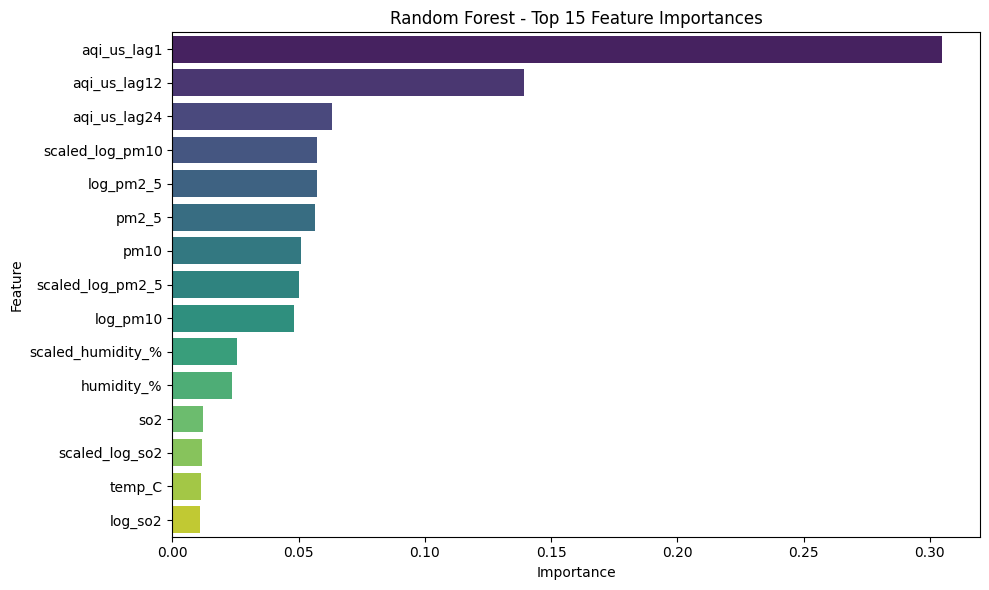

/tmp/ipython-input-21-78317768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


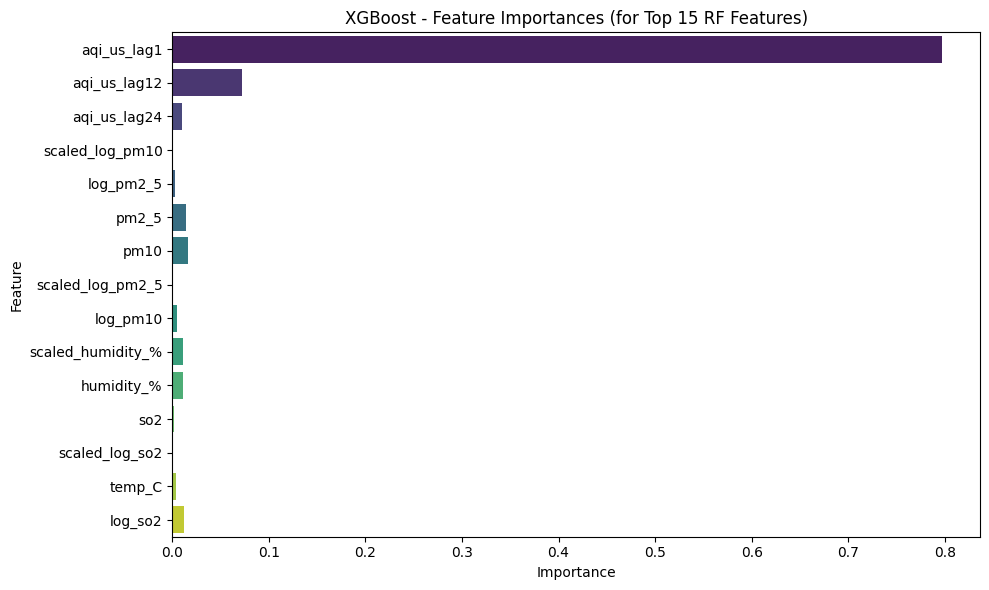

In [ ]:
# Random Forest
plot_importances(rf_importances, "Random Forest - Top 15 Feature Importances")

# XGBoost
xgb_top15 = xgb_importances[rf_importances.index]
plot_importances(xgb_top15, "XGBoost - Feature Importances (for Top 15 RF Features)")

In [ ]:
# Table of Importances

importance_df = pd.DataFrame({
    "Feature": rf_importances.index,
    "RandomForest_Importance": rf_importances.values,
    "XGBoost_Importance": xgb_importances[rf_importances.index].values
})

print("\n📊 Top 15 Features by Model Importance:\n")
print(importance_df.head(15).to_string(index=False))


📊 Top 15 Features by Model Importance:

          Feature  RandomForest_Importance  XGBoost_Importance
      aqi_us_lag1                 0.304678            0.796721
     aqi_us_lag12                 0.139114            0.072263
     aqi_us_lag24                 0.063416            0.009836
  scaled_log_pm10                 0.057227            0.000000
        log_pm2_5                 0.057093            0.002684
            pm2_5                 0.056306            0.014439
             pm10                 0.051063            0.015924
 scaled_log_pm2_5                 0.050317            0.000000
         log_pm10                 0.048028            0.004291
scaled_humidity_%                 0.025772            0.011109
       humidity_%                 0.023447            0.011018
              so2                 0.012030            0.002061
   scaled_log_so2                 0.011855            0.000000
           temp_C                 0.011193            0.003313
          log_

In [ ]:
import mlflow.sklearn
import mlflow.xgboost

# Common logging helper
def log_model_mlflow(model, model_name, params, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Predict and log metrics
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = mse**0.5
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        # Log model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        print(f"✅ Logged {model_name} to MLflow with RMSE: {rmse:.3f}")

In [ ]:
# Log all 4 models

# 1. RF (CV)
log_model_mlflow(
    best_rf,
    "RandomForest_CV_lagged_features",
    rf_grid.best_params_,
    X_test,
    y_test
)

# 2. RF (Optuna)
log_model_mlflow(
    best_rf_optuna,
    "RandomForest_Optuna_lagged_features",
    rf_study.best_params,
    X_test,
    y_test
)

# 3. XGB (CV)
log_model_mlflow(
    best_xgb,
    "XGBoost_CV_lagged_features",
    xgb_grid.best_params_,
    X_test,
    y_test
)

# 4. XGB (Optuna)
log_model_mlflow(
    best_xgb_optuna,
    "XGBoost_Optuna_lagged_features",
    xgb_study.best_params,
    X_test,
    y_test
)

2025/07/03 22:37:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 22:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged RandomForest_CV_lagged_features to MLflow with RMSE: 3.031


2025/07/03 22:37:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 22:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 22:37:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged RandomForest_Optuna_lagged_features to MLflow with RMSE: 3.003


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:37:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/03 22:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 22:37:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged XGBoost_CV_lagged_features to MLflow with RMSE: 1.960


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:37:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/03 22:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged XGBoost_Optuna_lagged_features to MLflow with RMSE: 1.859


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create destination folder if it doesn't exist
!mkdir -p /content/drive/MyDrive/mlflow_backup/mlruns

# Copy new runs to backup folder without overwriting existing ones
!rsync -av mlruns/ /content/drive/MyDrive/mlflow_backup/mlruns/

# Optional: if your mlflow.db may have new experiments or runs, replace it (or merge it later manually if needed)
!cp mlflow.db /content/drive/MyDrive/mlflow_backup/

sending incremental file list
./
1/
1/models/
1/models/m-122949c372744d1bbfa6bdafdac86374/
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/MLmodel
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/conda.yaml
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/model.pkl
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/python_env.yaml
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/requirements.txt
1/models/m-a0a26462e24740fd8b6b7076f67d759b/
1/models/m-a0a26462e24740fd8b6b7076f67d759b/artifacts/
1/models/m-a0a26462e24740fd8b6b7076f67d759b/artifacts/MLmodel
1/models/m-a0a26462e24740fd8b6b7076f67d759b/artifacts/conda.yaml
1/models/m-a0a26462e24740fd8b6b7076f67d759b/artifacts/model.xgb
1/models/m-a0a26462e24740fd8b6b7076f67d759b/artifacts/python_env.yaml
1/models/m-a0a26462e24740fd8b6b7076f67d759b/artifacts/requirements.txt
1/models/m-a99e9f5c9d134629b300e691b75610f4/
1/models/m-a99e9f5c9d134629b300e691b75610f4/a

In [7]:
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data_with_all_features.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   datetime                            2184 non-null   object 
 1   temp_C                              2184 non-null   float64
 2   humidity_%                          2184 non-null   float64
 3   windspeed_kph                       2184 non-null   float64
 4   precip_mm                           2184 non-null   float64
 5   pm10                                2184 non-null   float64
 6   pm2_5                               2184 non-null   float64
 7   co                                  2184 non-null   int64  
 8   no2                                 2184 non-null   float64
 9   so2                                 2184 non-null   float64
 10  o3                                  2184 non-null   int64  
 11  log_co                              2184 no

In [9]:
# features and target
target = "aqi_us"
excluded_cols = ["aqi_us", "datetime"]  # you may also test with or without lag features
features = [col for col in df.columns if col not in excluded_cols]

X = df[features]
y = df[target]

In [10]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# CV for Random Forest

rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 750],
    "max_depth": [6, 25, None],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", "log2"]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print("✅ Best Parameters for Random Forest:")
print(rf_grid.best_params_)

print("\n📉 Best CV MSE (neg):", rf_grid.best_score_)
print("📈 Best CV RMSE:", (-rf_grid.best_score_)**0.5)

✅ Best Parameters for Random Forest:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750}

📉 Best CV MSE (neg): -17.90366336121672
📈 Best CV RMSE: 4.231272073646023


In [13]:
# Optuna for Random Forest

def rf_objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 750),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    model = RandomForestRegressor(**rf_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=50)
best_rf_optuna = RandomForestRegressor(**rf_study.best_params, random_state=42)
best_rf_optuna.fit(X_train, y_train)

[I 2025-07-04 00:04:39,863] A new study created in memory with name: no-name-d3e8f2f7-e426-4401-864e-125e7502f0e7
[I 2025-07-04 00:04:42,542] Trial 0 finished with value: 11.336710077018736 and parameters: {'n_estimators': 391, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 11.336710077018736.
[I 2025-07-04 00:04:46,403] Trial 1 finished with value: 11.140778458582595 and parameters: {'n_estimators': 553, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 11.140778458582595.
[I 2025-07-04 00:04:50,907] Trial 2 finished with value: 9.49117795537342 and parameters: {'n_estimators': 537, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 9.49117795537342.
[I 2025-07-04 00:04:56,538] Trial 3 finished with value: 10.724159631131782 and parameters: {'n_estimators': 657, 'max_depth': 18, 'min_s

RandomForestRegressor(max_depth=22, max_features='sqrt', n_estimators=547,
                      random_state=42)

In [14]:
# CV for XGboost

xgb = XGBRegressor(random_state=42)
xgb_param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print("✅ Best Parameters for Xgboost:")
print(xgb_grid.best_params_)

print("\n📉 Best CV MSE (neg):", xgb_grid.best_score_)
print("📈 Best CV RMSE:", (-xgb_grid.best_score_)**0.5)

✅ Best Parameters for Xgboost:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}

📉 Best CV MSE (neg): -5.403469705581665
📈 Best CV RMSE: 2.324536449613485


In [15]:
# Optuna for XGboost

def xgb_objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0)
    }
    model = XGBRegressor(**xgb_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=50)
best_xgb_optuna = XGBRegressor(**xgb_study.best_params, random_state=42)
best_xgb_optuna.fit(X_train, y_train)

[I 2025-07-04 00:34:14,332] A new study created in memory with name: no-name-5a729a16-a14c-40ae-a9bf-9aa1ce1fcb65
[I 2025-07-04 00:34:14,814] Trial 0 finished with value: 6.2726216316223145 and parameters: {'n_estimators': 130, 'max_depth': 9, 'learning_rate': 0.2979682146428858, 'subsample': 0.9367227727646505, 'colsample_bytree': 0.9778362415605654, 'gamma': 0.8683480042965254, 'reg_alpha': 0.6973454703125705, 'reg_lambda': 0.7500705928197359}. Best is trial 0 with value: 6.2726216316223145.
[I 2025-07-04 00:34:15,659] Trial 1 finished with value: 4.188705921173096 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.2686601871199412, 'subsample': 0.6926770246759072, 'colsample_bytree': 0.903168096732298, 'gamma': 0.11286113226390415, 'reg_alpha': 0.21578797103595626, 'reg_lambda': 0.8851847885493718}. Best is trial 1 with value: 4.188705921173096.
[I 2025-07-04 00:34:17,462] Trial 2 finished with value: 5.302538871765137 and parameters: {'n_estimators': 303, 'max

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9892338907714412, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.2549584187011502,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0663513202524247,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=347, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Extract feature importances
rf_importances = pd.Series(best_rf_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]
xgb_importances = pd.Series(best_xgb_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [17]:
# Plotting Function
def plot_importances(importances, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-17-78317768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


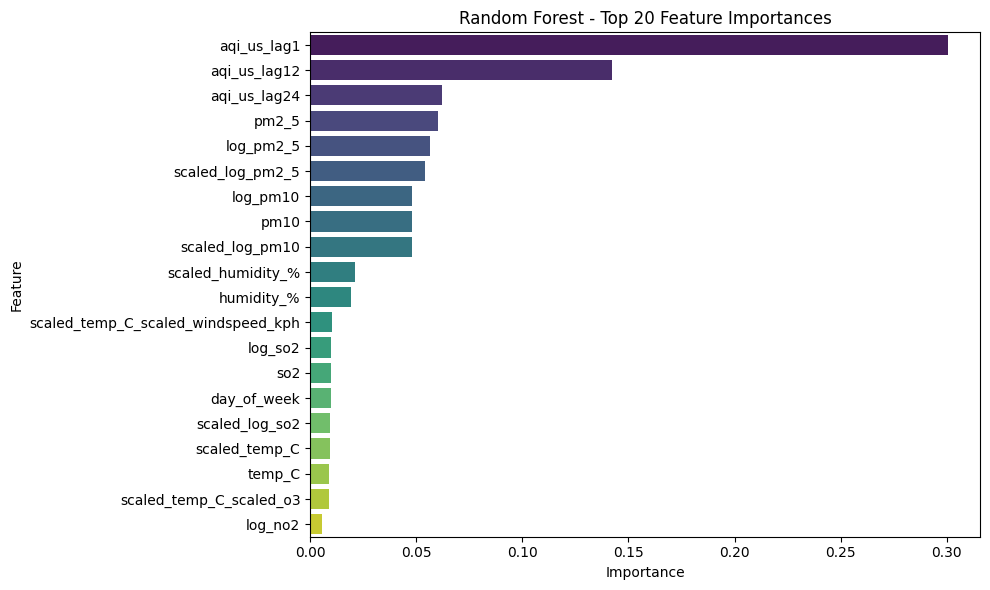

/tmp/ipython-input-17-78317768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


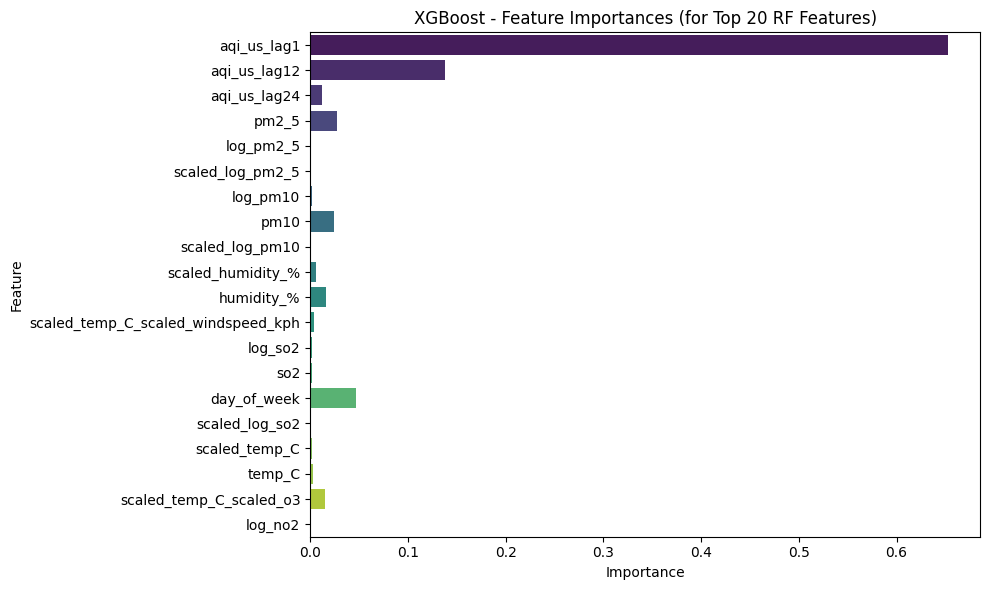

In [18]:
# Random Forest
plot_importances(rf_importances, "Random Forest - Top 20 Feature Importances")

# XGBoost
xgb_top20 = xgb_importances[rf_importances.index]
plot_importances(xgb_top20, "XGBoost - Feature Importances (for Top 20 RF Features)")

In [19]:
import mlflow.sklearn
import mlflow.xgboost

# Common logging helper
def log_model_mlflow(model, model_name, params, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Predict and log metrics
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = mse**0.5
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        # Log model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        print(f"✅ Logged {model_name} to MLflow with RMSE: {rmse:.3f}")

In [20]:
# Log all 4 models

# 1. RF (CV)
log_model_mlflow(
    best_rf,
    "RandomForest_CV_lagged+interaction_features",
    rf_grid.best_params_,
    X_test,
    y_test
)

# 2. RF (Optuna)
log_model_mlflow(
    best_rf_optuna,
    "RandomForest_Optuna_lagged+interaction_features",
    rf_study.best_params,
    X_test,
    y_test
)

# 3. XGB (CV)
log_model_mlflow(
    best_xgb,
    "XGBoost_CV_lagged+interaction_features",
    xgb_grid.best_params_,
    X_test,
    y_test
)

# 4. XGB (Optuna)
log_model_mlflow(
    best_xgb_optuna,
    "XGBoost_Optuna_lagged+interaction_features",
    xgb_study.best_params,
    X_test,
    y_test
)

2025/07/04 00:39:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/04 00:39:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged RandomForest_CV_lagged+interaction_features to MLflow with RMSE: 2.821


2025/07/04 00:39:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/04 00:39:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/04 00:39:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged RandomForest_Optuna_lagged+interaction_features to MLflow with RMSE: 2.825


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:39:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/04 00:39:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/04 00:39:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:39:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


✅ Logged XGBoost_CV_lagged+interaction_features to MLflow with RMSE: 1.926


2025/07/04 00:39:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged XGBoost_Optuna_lagged+interaction_features to MLflow with RMSE: 1.736


In [21]:
# Create destination folder if it doesn't exist
!mkdir -p /content/drive/MyDrive/mlflow_backup/mlruns

# Copy new runs to backup folder without overwriting existing ones
!rsync -av mlruns/ /content/drive/MyDrive/mlflow_backup/mlruns/

# Optional: if your mlflow.db may have new experiments or runs, replace it (or merge it later manually if needed)
!cp mlflow.db /content/drive/MyDrive/mlflow_backup/

sending incremental file list
./
1/
1/models/
1/models/m-122949c372744d1bbfa6bdafdac86374/
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/MLmodel
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/conda.yaml
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/model.pkl
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/python_env.yaml
1/models/m-122949c372744d1bbfa6bdafdac86374/artifacts/requirements.txt
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/artifacts/
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/artifacts/MLmodel
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/artifacts/conda.yaml
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/artifacts/model.pkl
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/artifacts/python_env.yaml
1/models/m-5e2c1e01eebe43ca9bb7c429e57cc7b2/artifacts/requirements.txt
1/models/m-a0a26462e24740fd8b6b7076f67d759b/
1/models/m-a0a26462e24740fd8b6b7076f67d759b/a